# Beijing Air Quality Forecasting Starter Notebook

In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [71]:
# Mount Google Drive to access datasets
#from google.colab import drive
#drive.mount('/content/drive')

In [72]:
# Load the datasets

train = pd.read_csv('C:\\Users\\USER\\ML Tech 1\\Assignment-1--Time-Series-Forecasting\\train.csv', index_col=None)
test = pd.read_csv('C:\\Users\\USER\\ML Tech 1\\Assignment-1--Time-Series-Forecasting\\test.csv', index_col=None)
sample_submission_path = 'C:\\Users\\USER\\ML Tech 1\\Assignment-1--Time-Series-Forecasting\\sample_submission.csv'

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [73]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()
train.describe()


Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [74]:
print("\nTesting Data Overview:")
print(test.head())


Testing Data Overview:
      No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0  30677  1.190496  0.701029 -2.186052 -0.003982 -0.069353 -0.137667   
1  30678  1.121211  0.619051 -2.186052  0.031811 -0.069353 -0.137667   
2  30679  1.190496  0.783006 -2.186052  0.094398 -0.069353 -0.137667   
3  30680  1.190496  0.946961 -2.088668  0.174782 -0.069353 -0.137667   
4  30681  1.190496  1.192893 -1.991283  0.210575 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  
0  2013-07-02 04:00:00  1.448138 -0.732019 -0.522096  
1  2013-07-02 05:00:00  1.448138 -0.732019 -0.522096  
2  2013-07-02 06:00:00  1.448138 -0.732019 -0.522096  
3  2013-07-02 07:00:00  1.448138 -0.732019 -0.522096  
4  2013-07-02 08:00:00  1.448138 -0.732019 -0.522096  


Text(0, 0.5, 'Frequency')

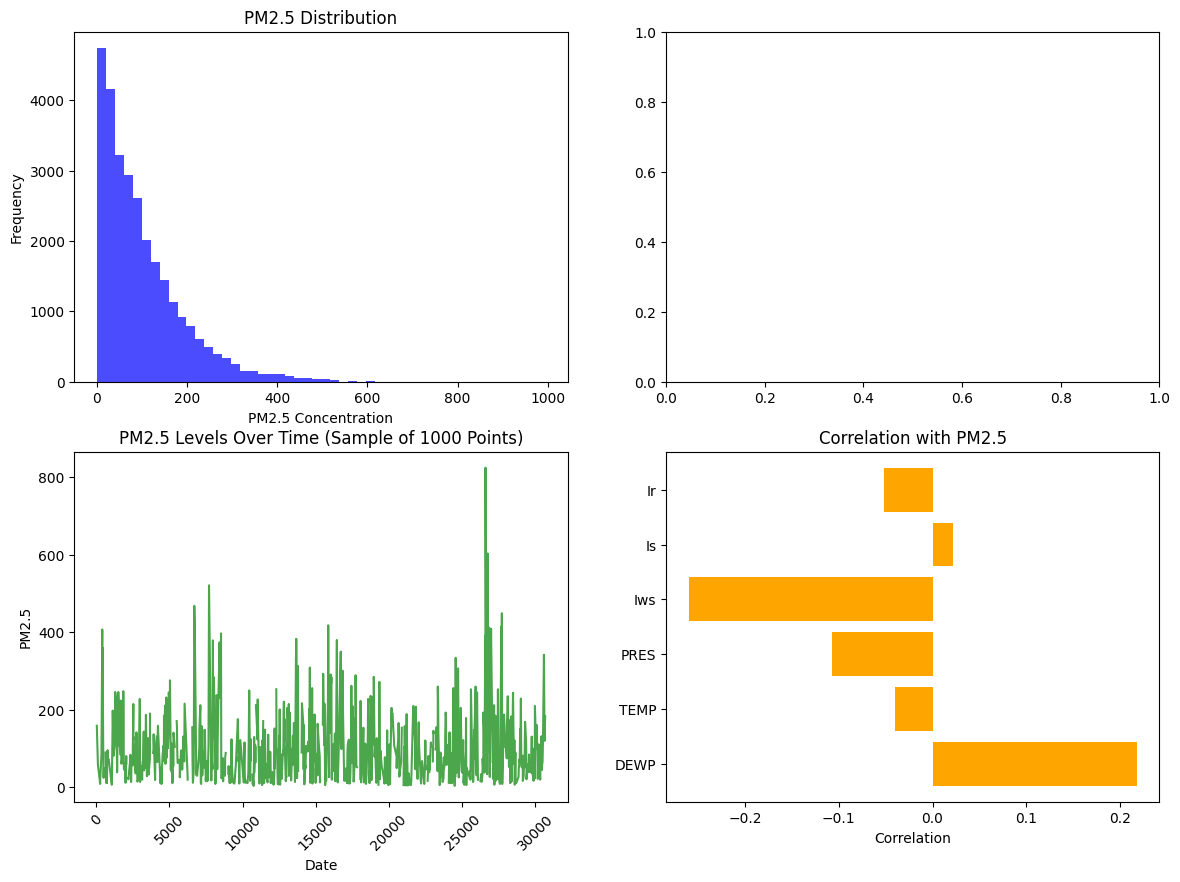

In [75]:
import seaborn as sns

# Create a 2x2 grid of subplots
axes = plt.subplots(2, 2, figsize=(14, 10))[1]
# PM2.5 
sample_data = train.sample(n=min(1000, len(train))).sort_index()
axes[1,0].plot(sample_data.index, sample_data['pm2.5'], alpha=0.7, color='green')
axes[1,0].set_title('PM2.5 Levels Over Time (Sample of 1000 Points)')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('PM2.5')
axes[1,0].tick_params(axis='x', rotation=45)

# correlation
numeric_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
correlations = train[numeric_cols + ['pm2.5']].corr()['pm2.5'].drop('pm2.5')
axes[1,1].barh(range(len(correlations)), correlations.values, color='orange')
axes[1,1].set_title('Correlation with PM2.5')
axes[1,1].set_yticks(range(len(correlations)))
axes[1,1].set_yticklabels(correlations.index)
axes[1,1].set_xlabel('Correlation')
# PM2.5 Distribution

axes[0,0].hist(train['pm2.5'].dropna(), bins=50, color='blue', alpha=0.7)
axes[0,0].set_title('PM2.5 Distribution')
axes[0,0].set_xlabel('PM2.5 Concentration')
axes[0,0].set_ylabel('Frequency')

In [76]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [77]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
# Feature Engineering
def create_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['season'] = df['month'].apply(lambda x: (x%12 + 3)//3)
    return df



In [78]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [79]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
   metrics=[tf.keras.metrics.MeanSquaredError()] # MSE metric
)

# Display the model architecture
model.summary()



C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
%pip install tensorflow

# Train the model with validation split and callbacks to prevent data loss
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Callback to stop training when validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback to save the best model during training
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, model_checkpoint]
)

# Load the best model after training
model = load_model('best_lstm_model.keras')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 13649.9678 - mean_squared_error: 13649.9678 - val_loss: 15883.3076 - val_mean_squared_error: 15883.3076
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 7971.7251 - mean_squared_error: 7971.7251 - val_loss: 11471.8418 - val_mean_squared_error: 11471.8418
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6632.4634 - mean_squared_error: 6632.4634 - val_loss: 9653.3438 - val_mean_squared_error: 9653.3438
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5850.7202 - mean_squared_error: 5850.7202 - val_loss: 8576.5127 - val_mean_squared_error: 8576.5127
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 5471.3174 - mean_squared_error: 5471.3174 - val_loss: 8020.7354 - val_mean_squared_error: 8020.7354
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 5281.2349 - mean_squared_error: 5281.2349 - val_loss: 7727.2417 - val_mean_squared_error: 7727.2417
Epoch 7/50
767/767 ━━━━━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


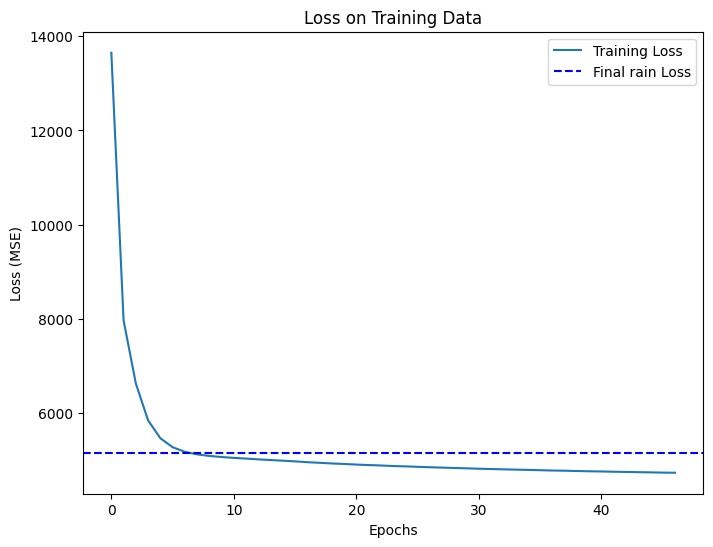

Final Training Loss (MSE): 5168.5069395366245


In [82]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [86]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv("sample_submission.csv", index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
